In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


import seaborn as sns
import warnings
import os
from scipy.interpolate import griddata



from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
from keras.callbacks import ModelCheckpoint


from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

import meshio
import re

In [2]:
import cfdnetplus

In [37]:
path_to_main= 'airfoil2d/'
folders=['airFoil_1000', 'airFoil_30', 'airFoil_300','airFoil_600', 'airFoil_3000', 'airFoil_2000']
fields= ['U','p','k','omega', 'nut']
xlim =[-50,50]
ylim = [-30 , 30]
xres=256
yres=66
zcut=0.05
modelid='model_ssim'

In [4]:
cfdnetplus.VTK2np(path_to_main,folders, fields,'xy' ,xres,yres,xlim,ylim,zcut)

processing data in airfoil2d/airFoil_1000/VTK/
(339, 66, 256, 7)
339
[266]
data written toairfoil2d/airFoil_1000/VTK/df
processing data in airfoil2d/airFoil_30/VTK/
(600, 66, 256, 7)
600
[555]
data written toairfoil2d/airFoil_30/VTK/df
processing data in airfoil2d/airFoil_300/VTK/
(338, 66, 256, 7)
338
[265]
data written toairfoil2d/airFoil_300/VTK/df
processing data in airfoil2d/airFoil_600/VTK/
(338, 66, 256, 7)
338
[265]
data written toairfoil2d/airFoil_600/VTK/df
processing data in airfoil2d/airFoil_3000/VTK/
(340, 66, 256, 7)
340
[267]
data written toairfoil2d/airFoil_3000/VTK/df
processing data in airfoil2d/airFoil_2000/VTK/
(340, 66, 256, 7)
340
[267]
data written toairfoil2d/airFoil_2000/VTK/df


['airfoil2d/airFoil_1000/VTK/',
 'airfoil2d/airFoil_30/VTK/',
 'airfoil2d/airFoil_300/VTK/',
 'airfoil2d/airFoil_600/VTK/',
 'airfoil2d/airFoil_3000/VTK/',
 'airfoil2d/airFoil_2000/VTK/']

In [38]:

df = np.empty((0,66,256,7))
df_label = np.empty((0,66,256,7))
path_to_folders=[]
for i in folders:
    path_to_folders.append(path_to_main+i+'/VTK/')
    df_t=np.load(path_to_main+i+'/VTK/df.npy')
    df_tlabel=np.load(path_to_main+i+'/VTK/df_label.npy')
    df=np.concatenate((df,df_t))
    df_label=np.concatenate((df_label,df_tlabel))
print(df_label.shape)

(2295, 66, 256, 7)


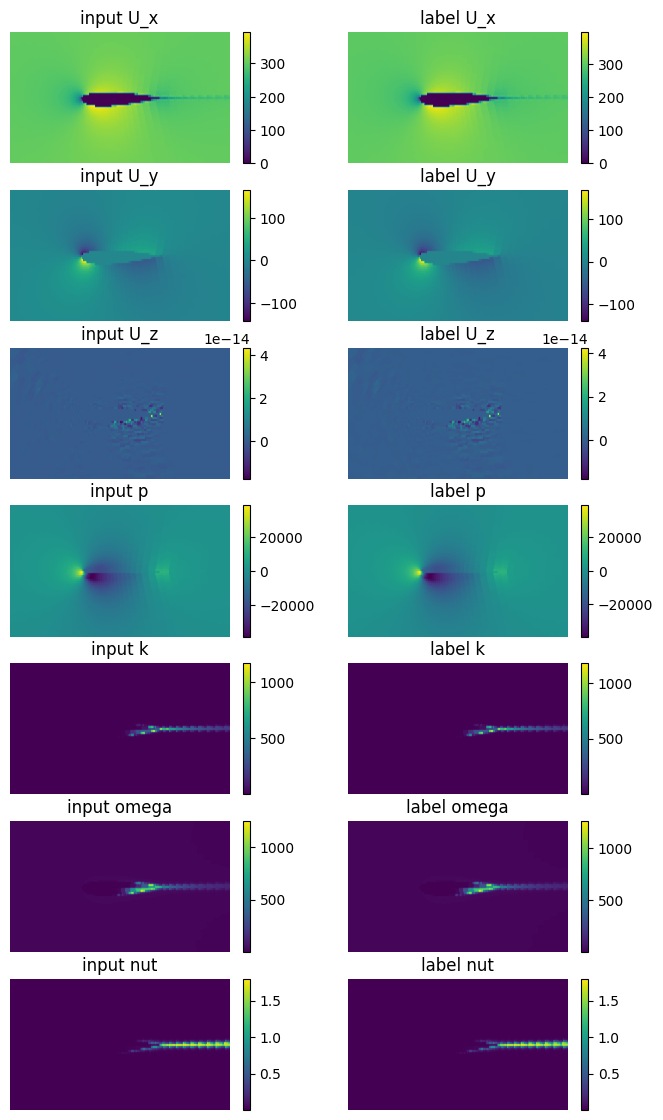

In [5]:

n=1000
fig = plt.figure(figsize=(8, 14))
[a,b,c,d]=df.shape
titles= ['U_x','U_y','U_z','p','k','omega', 'nut']

for i in range(d):
    fig.add_subplot(d, 2, i*2+1)
    plt.imshow(df[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('input ' +titles[i])
    plt.axis('off')
    plt.colorbar()
    
    fig.add_subplot(d, 2, i*2+2)
    plt.imshow(df_label[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('label '+titles[i])
    plt.axis('off')
    plt.colorbar()
    #print(i)

plt.show()

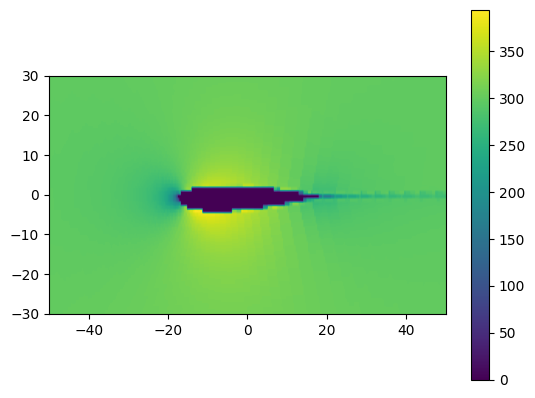

In [6]:
plt.imshow(df[1000,:,:,0],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.colorbar()

In [7]:
df_label[n,:,:,3].shape

(66, 256)

In [39]:
#normalise U Vektors
U_max=np.max(abs(df[:,:,:,[0,1,2]]))
p_max=np.max(abs(df[:,:,:,[3]]))
k_max=np.max(abs(df[:,:,:,[4]]))
omega_max=np.max(abs(df[:,:,:,[5]]))
nut_max=np.max(abs(df[:,:,:,[6]]))

model_path='cfdnetplus_models/'+modelid+'/'
normal=np.array([U_max,U_max,U_max, p_max,k_max, omega_max,nut_max]).reshape(1,1,1,7)
print(normal)

if os.path.isdir(model_path)== False:
    os.mkdir(model_path)
np.save(model_path+'normal',normal)


[[[[4.41323047e+03 4.41323047e+03 4.41323047e+03 7.33556320e+07
    2.83279031e+05 1.93653164e+04 4.86423264e+01]]]]


In [40]:
contents=''
for field in fields:
    contents=contents+field+ '\n'
print(contents)
with open(model_path+'fields',"w") as f:
            f.writelines(contents)
dims=np.array([xres,yres,xlim[0],xlim[1],ylim[0],ylim[1],zcut])
np.save(model_path+'dims',dims)

U
p
k
omega
nut



In [10]:
df1=df*1/normal
df_label1=df_label/normal

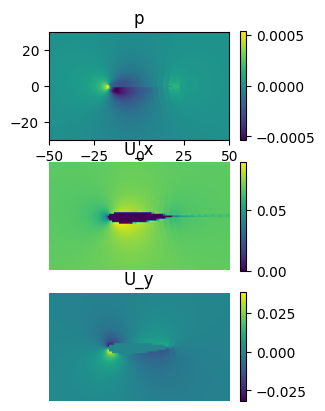

In [11]:
fig = plt.figure()

fig.add_subplot(3, 2, 1)
plt.imshow(df_label1[n,:,:,3],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('p')
plt.axis('on')
plt.colorbar()


fig.add_subplot(3, 2, 3)
plt.imshow(df_label1[n,:,:,0],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('U_x')
plt.axis('off')
plt.colorbar()

fig.add_subplot(3, 2, 5)
plt.imshow(df_label1[n,:,:,1],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('U_y')
plt.axis('off')

plt.colorbar()
plt.show()

In [12]:
train_data, test_data, label_train, label_test = train_test_split (df1, df_label1, test_size = 0.15)

In [13]:
ylim[1]

30

20


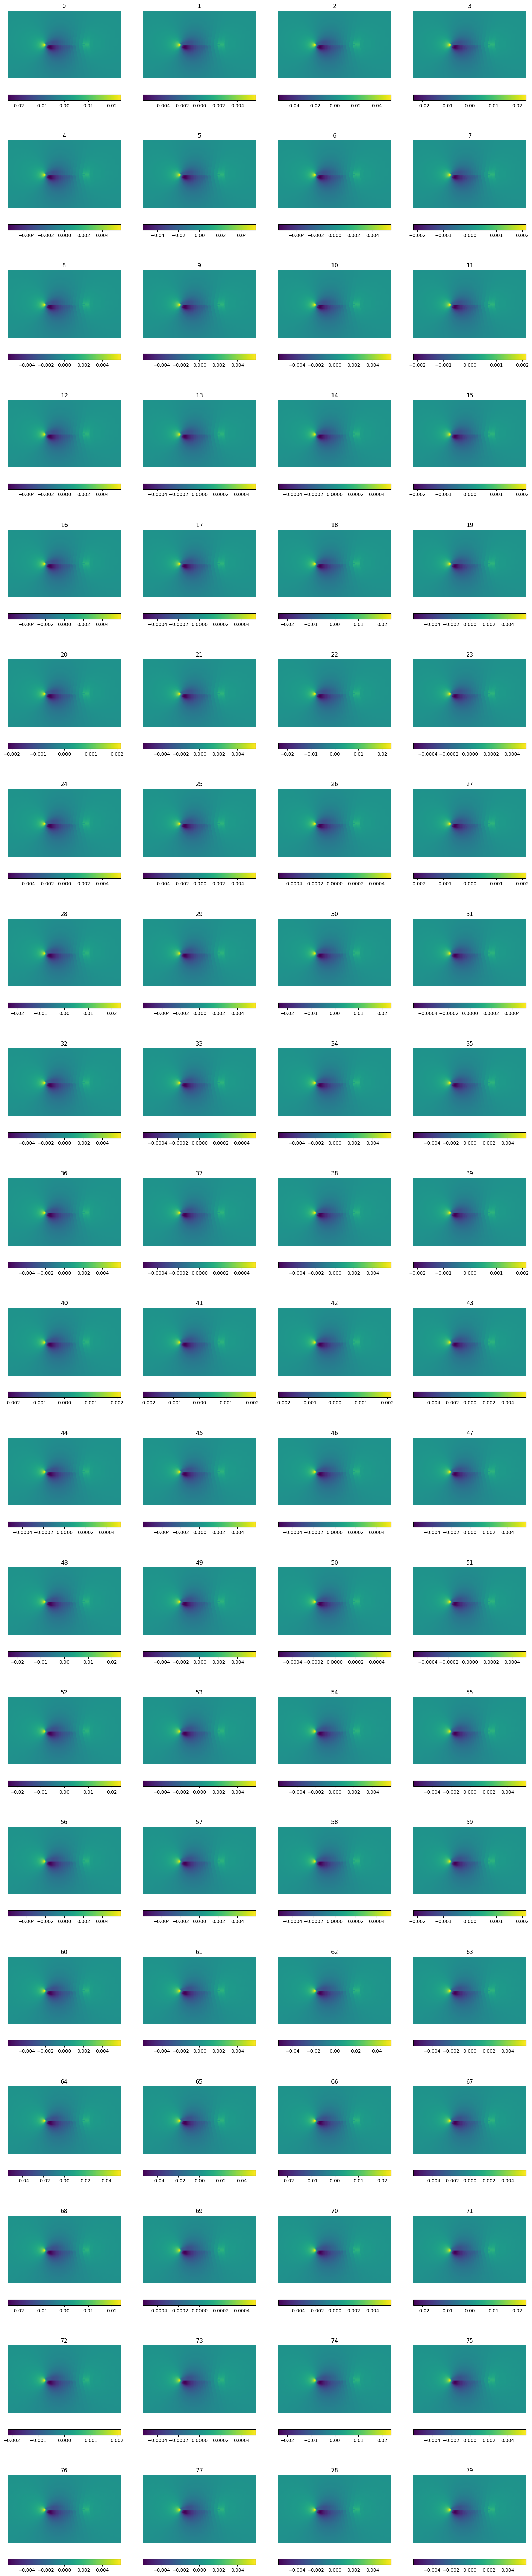

In [17]:
[a,b,c,d]=label_train.shape
fig = plt.figure(figsize=(20, 100))
columns = 4
rows = 20
print(rows)

for i in range( columns * rows):
    img = label_train[(i-1),:,:,3]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img,extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title(i)
    plt.axis('off')
    plt.colorbar(location='bottom')

plt.show()

In [15]:
# Valid for input with four layers
model = models.Sequential()
model.add(layers.Conv2D(16,( 4,12), (2, 8), activation='tanh',padding="same", input_shape=(66,256, 7)))
model.add(layers.Conv2D(64,(6), (3, 4), activation='tanh',padding="same",))
model.add(layers.Conv2D(256,(16,12), (11, 8), activation='tanh',padding="same",))
model.add(layers.Conv2DTranspose(32,(14,10),(11,8), activation='tanh',padding="same"))
model.add(layers.Conv2DTranspose(16,(6,8),(3,4), activation='tanh',padding="same"))
model.add(layers.Conv2DTranspose(7,(4,16),(2,8), activation='PReLU', padding="same"))

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 33, 32, 16)        5392      
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 8, 64)         36928     
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 1, 256)         3145984   
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 11, 8, 32)        1146912   
 ranspose)                                                       
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 33, 32, 16)       24592     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 66, 256, 7)      

In [18]:
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [19]:
model.compile(optimizer='adam',
              loss=SSIMLoss)

In [20]:
folders=os.listdir('training/')
print(folders)
sub='training_'
folders = [x for x in folders if re.search(sub, x)]
#print(len(folders))
if len(folders)==0:
    filefolder=sub+'0'
else:
    id=[]
    for txt in folders:
        t=txt.split('_')
        id.append(int(t[len(t)-1]))
    index_max=np.argmax(id)
    filefolder= sub+str(id[index_max]+1)
print(filefolder)

['training_0', 'training_1', 'training_10', 'training_11', 'training_12', 'training_13', 'training_14', 'training_15', 'training_16', 'training_17', 'training_18', 'training_19', 'training_2', 'training_20', 'training_21', 'training_22', 'training_3', 'training_4', 'training_5', 'training_6', 'training_7', 'training_8', 'training_9']
training_23


In [21]:
filepath ='training/'+ filefolder+'/'+'vae_best_model_relu.epoch{epoch:02d}-loss{loss:.5f}.w'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=1,
                             save_weights_only=True,
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

In [22]:
history = model.fit(train_data, label_train, epochs=100, 
                    validation_data=(test_data, label_test),
                    batch_size=32,
                   callbacks=callbacks)

Epoch 1/100
61/61 [==============================] - ETA: 0s - loss: 0.0996
Epoch 1: loss improved from inf to 0.09965, saving model to training/training_23\vae_best_model_relu.epoch01-loss0.09965.w
61/61 [==============================] - 65s 1s/step - loss: 0.0996 - val_loss: 0.0287
Epoch 2/100
61/61 [==============================] - ETA: 0s - loss: 0.0243
Epoch 2: loss improved from 0.09965 to 0.02429, saving model to training/training_23\vae_best_model_relu.epoch02-loss0.02429.w
61/61 [==============================] - 61s 998ms/step - loss: 0.0243 - val_loss: 0.0157
Epoch 3/100
61/61 [==============================] - ETA: 0s - loss: 0.0116
Epoch 3: loss improved from 0.02429 to 0.01159, saving model to training/training_23\vae_best_model_relu.epoch03-loss0.01159.w
61/61 [==============================] - 61s 1s/step - loss: 0.0116 - val_loss: 0.0080
Epoch 4/100
61/61 [==============================] - ETA: 0s - loss: 0.0445
Epoch 4: loss did not improve from 0.01159
61/61 [=====

61/61 [==============================] - 58s 955ms/step - loss: 0.0012 - val_loss: 8.3308e-04
Epoch 35/100
61/61 [==============================] - ETA: 0s - loss: 0.0016
Epoch 35: loss did not improve from 0.00119
61/61 [==============================] - 57s 943ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 36/100
61/61 [==============================] - ETA: 0s - loss: 9.3521e-04
Epoch 36: loss improved from 0.00119 to 0.00094, saving model to training/training_23\vae_best_model_relu.epoch36-loss0.00094.w
61/61 [==============================] - 57s 944ms/step - loss: 9.3521e-04 - val_loss: 8.3751e-04
Epoch 37/100
61/61 [==============================] - ETA: 0s - loss: 0.0014
Epoch 37: loss did not improve from 0.00094
61/61 [==============================] - 58s 946ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 38/100
61/61 [==============================] - ETA: 0s - loss: 0.0013
Epoch 38: loss did not improve from 0.00094
61/61 [==============================] - 61s 1s/step - l

61/61 [==============================] - ETA: 0s - loss: 8.5321e-04
Epoch 72: loss did not improve from 0.00083
61/61 [==============================] - 58s 943ms/step - loss: 8.5321e-04 - val_loss: 8.5848e-04
Epoch 73/100
61/61 [==============================] - ETA: 0s - loss: 0.0013
Epoch 73: loss did not improve from 0.00083
61/61 [==============================] - 57s 941ms/step - loss: 0.0013 - val_loss: 9.6276e-04
Epoch 74/100
61/61 [==============================] - ETA: 0s - loss: 7.1217e-04
Epoch 74: loss improved from 0.00083 to 0.00071, saving model to training/training_23\vae_best_model_relu.epoch74-loss0.00071.w
61/61 [==============================] - 58s 949ms/step - loss: 7.1217e-04 - val_loss: 5.7272e-04
Epoch 75/100
61/61 [==============================] - ETA: 0s - loss: 0.0011
Epoch 75: loss did not improve from 0.00071
61/61 [==============================] - 57s 944ms/step - loss: 0.0011 - val_loss: 7.0613e-04
Epoch 76/100
61/61 [==============================] -

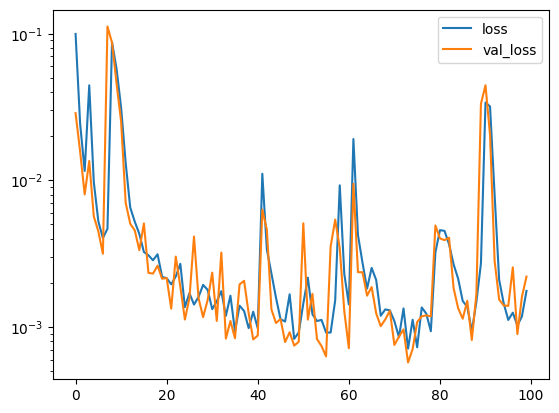

In [25]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
#plt.xlabel('Epoch')
#plt.ylabel('loss')
#plt.ylim([0.5, 1])
plt.yscale('log')
plt.legend(loc='upper right')

Finding the last epoch in the training folder

In [27]:
#filefolder= 'training_6'

folders=os.listdir('training/'+filefolder)
#folders=os.listdir('training/'+'training_0/')

sub='index'
folders = [x for x in folders if re.search(sub, x)]

ts=[]
for folder in folders:
    a=re.search('\d{2,3}',folder)
    ts.append(int(a.group(0)))
    #print(a.group(0))
index_max=np.max(ts)
print(index_max)
latest = [x for x in folders if re.search(str(index_max), x)]

latest=latest[0].split('.index')
print(latest[0])

74
vae_best_model_relu.epoch74-loss0.00071.w


In [28]:
weights_path='training/'+filefolder+'/'+latest[0]

#weights_path='training/'+'training_0'+'/'+latest[0]

print(weights_path)
model.load_weights(weights_path)

training/training_23/vae_best_model_relu.epoch74-loss0.00071.w


In [29]:
test=model.predict(test_data)

11/11 [==============================] - 1s 62ms/step


In [30]:
print(label_test.shape[0])
n=5
print('max:' , np.max(test[:,:,:,n]))
print('min:' , np.min(test[:,:,:,n]))
#label_test=label_test.reshape((36,66,256,4))
#plt.imshow(np.clip(label_test[1,:,:,3],0,1))

345
max: 0.653561
min: -0.0012377185


(345, 66, 256, 7)


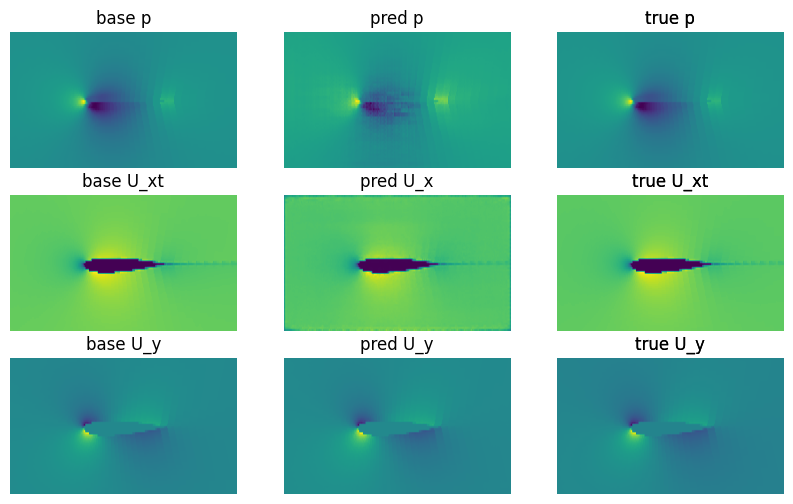

In [31]:
print(test_data.shape)
n=23
fig = plt.figure(figsize=(10, 6))

fig.add_subplot(3, 3, 2)
plt.imshow(test[n,:,:,3],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('pred p')
plt.axis('off')


fig.add_subplot(3, 3,5)
plt.imshow(test[n,:,:,0],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('pred U_x')
plt.axis('off')

fig.add_subplot(3, 3, 8)
plt.imshow(test[n,:,:,1],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('pred U_y')
plt.axis('off')

fig.add_subplot(3, 3, 1)
plt.imshow(test_data[n,:,:,3],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('base p')
plt.axis('off')


fig.add_subplot(3, 3,4)
plt.imshow(test_data[n,:,:,0],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('base U_xt')
plt.axis('off')

fig.add_subplot(3, 3, 7)
plt.imshow(test_data[n,:,:,1],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('base U_y')
plt.axis('off')

fig.add_subplot(3, 3, 3)
plt.imshow(label_test[n,:,:,3],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('true p')
plt.axis('off')


fig.add_subplot(3, 3,6)
plt.imshow(label_test[n,:,:,0],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('true U_xt')
plt.axis('off')

fig.add_subplot(3, 3, 9)
plt.imshow(label_test[n,:,:,1],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('true U_y')
plt.axis('off')

fig.add_subplot(3, 3, 3)
plt.imshow(label_test[n,:,:,3],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('true p')
plt.axis('off')


fig.add_subplot(3, 3,6)
plt.imshow(label_test[n,:,:,0],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('true U_xt')
plt.axis('off')

fig.add_subplot(3, 3, 9)
plt.imshow(label_test[n,:,:,1],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('true U_y')
plt.axis('off')


plt.show()

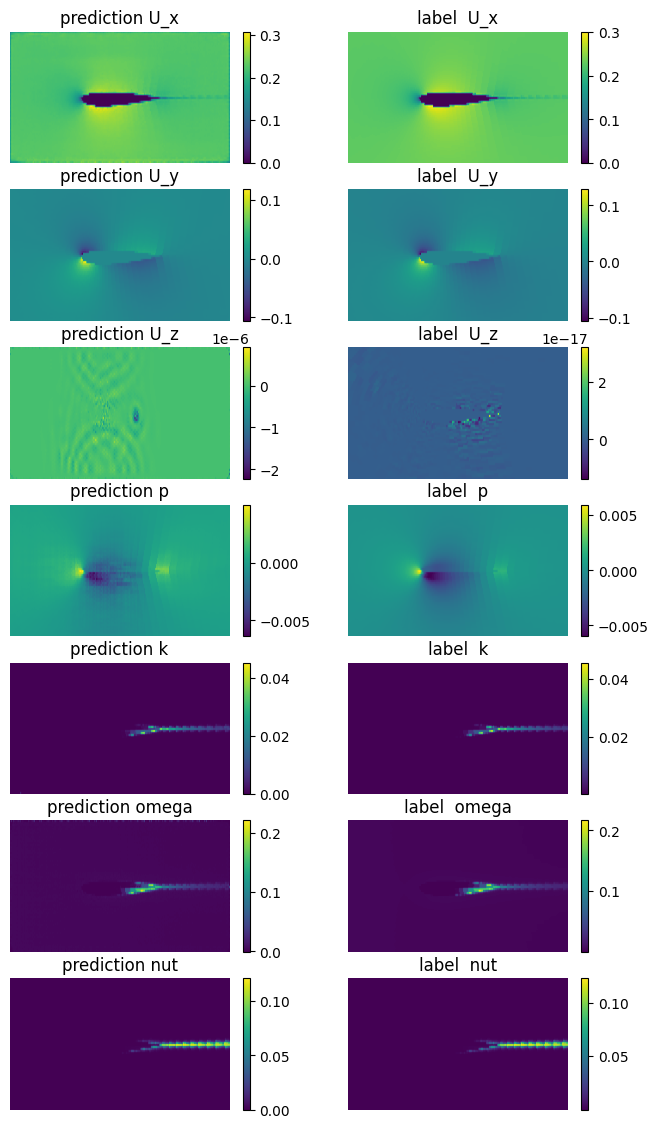

In [32]:
n=23
fig = plt.figure(figsize=(8, 14))
[a,b,c,d]=test.shape
titles= ['U_x','U_y','U_z','p','k','omega', 'nut']

for i in range(d):
    fig.add_subplot(d, 2, i*2+1)
    plt.imshow(test[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('prediction ' +titles[i])
    plt.axis('off')
    plt.colorbar()
    
    fig.add_subplot(d, 2, i*2+2)
    plt.imshow(label_test[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('label  '+titles[i])
    plt.axis('off')
    plt.colorbar()
    #print(i)

plt.show()

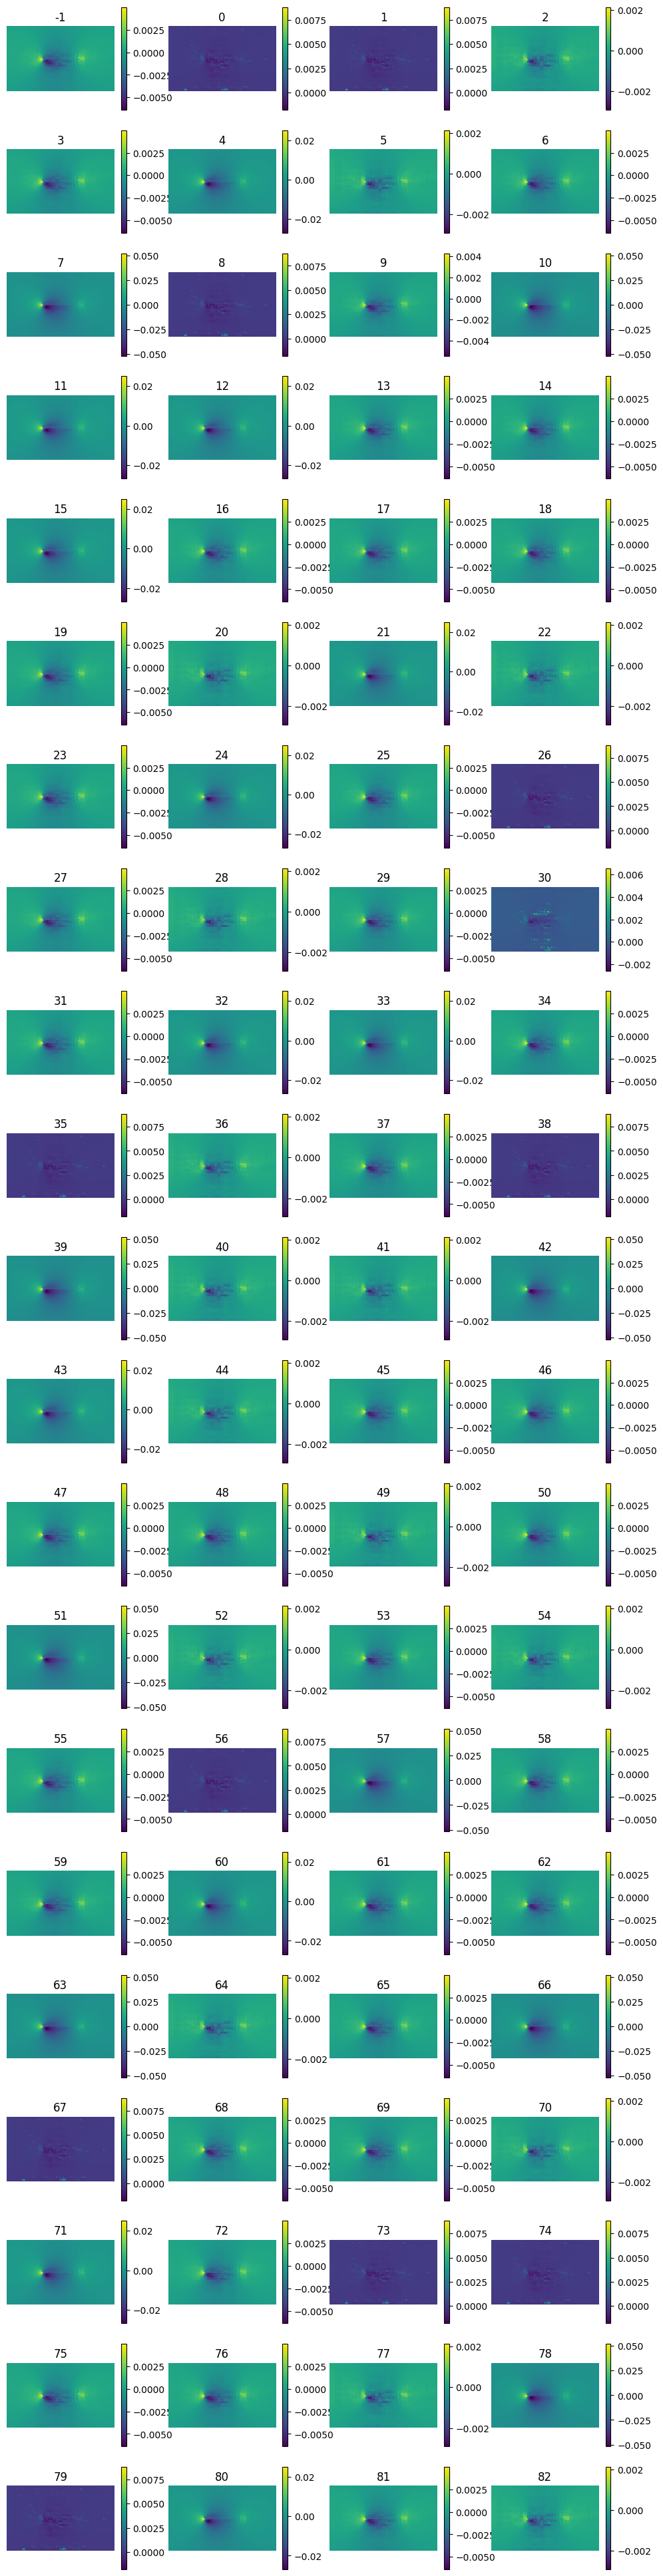

In [33]:
[a,b,c,d]=test.shape
fig = plt.figure(figsize=(12, 50))
columns = 4
rows = 21

for i in range( columns * rows):
    img = test[(i-1),:,:,3]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img,extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title(i-1)
    plt.axis('off')
    plt.colorbar()
plt.show()
    

In [34]:
mse=[]
ssim1=[]
for i in range(label_test.shape[0]):
    mse.append(mean_squared_error(test[i,:,:,3],label_test[i,:,:,3]))
    ssim1.append(ssim(test[i,:,:,3],label_test[i,:,:,3]))
print('max mse:'+ str(max(mse)))
print(ssim1[n])
print(mse[n])
mse=np.mean(mse)
ssim2=np.mean(ssim1[:])
print('average ssim: '+str(ssim2))
print('average mse: '+str(mse))

C:\Users\hansi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


max mse:2.0362468937169448e-07
0.9999409326314926
3.556620590069448e-08
average ssim: 0.9999249527716751
average mse: 6.725774283211873e-08


In [35]:
#os.mkdir('cfdnetplus_models')
model.save('cfdnetplus_models/model_ssim')

INFO:tensorflow:Assets written to: cfdnetplus_models/model_ssim\assets


INFO:tensorflow:Assets written to: cfdnetplus_models/model_ssim\assets
